In [2]:
from google.colab import files
import pandas as pd # Import the pandas library

uploaded = files.upload()

df = pd.read_csv('enhanced_student_habits_performance_dataset.csv')

Saving enhanced_student_habits_performance_dataset.csv to enhanced_student_habits_performance_dataset (1).csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split


# Fill missing values (if any)
df.fillna(method='ffill', inplace=True)

# Encode categorical features
categorical_cols = ['gender', 'major', 'part_time_job', 'diet_quality',
                    'parental_education_level', 'internet_quality', 'extracurricular_participation',
                    'dropout_risk', 'study_environment', 'access_to_tutoring',
                    'family_income_range', 'parental_support_level', 'learning_style']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Scale continuous features
continuous_cols = ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
                   'attendance_percentage', 'sleep_hours', 'exercise_frequency',
                   'mental_health_rating', 'previous_gpa', 'semester', 'stress_level',
                   'social_activity', 'screen_time', 'motivation_level',
                   'exam_anxiety_score', 'time_management_score', 'exam_score']

scaler = MinMaxScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

# Final feature matrix (exclude student_id, target variables for unsupervised embedding learning)
X = df.drop(columns=['student_id', 'dropout_risk', 'exam_score'])

print("Preprocessed feature matrix shape:", X.shape)


<ipython-input-3-b42306da7111>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Preprocessed feature matrix shape: (80000, 28)


In [4]:
import torch

def augment_data(x, noise_std=0.01, mask_prob=0.1):
    """Apply simple augmentations: additive noise + random feature masking."""
    x_aug = x + torch.randn_like(x) * noise_std
    mask = (torch.rand_like(x) > mask_prob).float()
    return x_aug * mask


In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class StudentDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data.values, dtype=torch.float32)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]

class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, out_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return F.normalize(self.net(x), dim=1)

def nt_xent_loss(z_i, z_j, temperature=0.5):
    """Normalized Temperature-scaled Cross Entropy Loss."""
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    sim = torch.mm(z, z.t()) / temperature
    sim_exp = torch.exp(sim)

    mask = (~torch.eye(2*batch_size, dtype=torch.bool)).to(z.device)
    sim_exp = sim_exp * mask

    pos_sim = torch.exp(torch.sum(z_i * z_j, dim=-1) / temperature)
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)

    loss = -torch.log(pos_sim / sim_exp.sum(dim=1))
    return loss.mean()

# Prepare dataset and dataloader
dataset = StudentDataset(X)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model and optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLPEncoder(input_dim=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 50
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        x_i = augment_data(batch)
        x_j = augment_data(batch)
        z_i = model(x_i)
        z_j = model(x_j)
        loss = nt_xent_loss(z_i, z_j)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")


Epoch 1, Loss: 3.4440
Epoch 2, Loss: 3.3497
Epoch 3, Loss: 3.3153
Epoch 4, Loss: 3.2878
Epoch 5, Loss: 3.2753
Epoch 6, Loss: 3.2634
Epoch 7, Loss: 3.2568
Epoch 8, Loss: 3.2557
Epoch 9, Loss: 3.2498
Epoch 10, Loss: 3.2495
Epoch 11, Loss: 3.2472
Epoch 12, Loss: 3.2471
Epoch 13, Loss: 3.2453
Epoch 14, Loss: 3.2417
Epoch 15, Loss: 3.2366
Epoch 16, Loss: 3.2285
Epoch 17, Loss: 3.2211
Epoch 18, Loss: 3.2199
Epoch 19, Loss: 3.2185
Epoch 20, Loss: 3.2167
Epoch 21, Loss: 3.2150
Epoch 22, Loss: 3.2148
Epoch 23, Loss: 3.2141
Epoch 24, Loss: 3.2123
Epoch 25, Loss: 3.2125
Epoch 26, Loss: 3.2113
Epoch 27, Loss: 3.2104
Epoch 28, Loss: 3.2102
Epoch 29, Loss: 3.2097
Epoch 30, Loss: 3.2080
Epoch 31, Loss: 3.2077
Epoch 32, Loss: 3.2074
Epoch 33, Loss: 3.2075
Epoch 34, Loss: 3.2051
Epoch 35, Loss: 3.2043
Epoch 36, Loss: 3.2044
Epoch 37, Loss: 3.2020
Epoch 38, Loss: 3.2023
Epoch 39, Loss: 3.2015
Epoch 40, Loss: 3.2012
Epoch 41, Loss: 3.1984
Epoch 42, Loss: 3.1973
Epoch 43, Loss: 3.1945
Epoch 44, Loss: 3.19

In [6]:
model.eval()
with torch.no_grad():
    embeddings = model(torch.tensor(X.values, dtype=torch.float32).to(device)).cpu().numpy()
print("Embeddings shape:", embeddings.shape)


Embeddings shape: (80000, 64)


In [7]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=fd0c3f051a0b1082aa45648350c83dcc5fbe0ca7eaa5b1c5ad0bb859f8260671
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [8]:
!pip install minisom
from minisom import MiniSom
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score

# Kohonen SOM clustering
som_size = 10
som = MiniSom(som_size, som_size, embeddings.shape[1], sigma=1.0, learning_rate=0.5)
som.train_random(embeddings, 1000)

# Assign SOM cluster labels
def som_cluster_labels(som, data):
    labels = []
    for x in data:
        w = som.winner(x)
        labels.append(w[0]*som_size + w[1])
    return np.array(labels)

som_labels = som_cluster_labels(som, embeddings)

# KMeans clustering
k = 10
kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
kmeans_labels = kmeans.labels_

# GMM clustering
gmm = GaussianMixture(n_components=k, random_state=42).fit(embeddings)
gmm_labels = gmm.predict(embeddings)

# Evaluation (if ground truth labels available, e.g. dropout_risk encoded as int)
# Assuming 'df' is available from previous cells and 'dropout_risk' is a column
true_labels = LabelEncoder().fit_transform(df['dropout_risk'])  # Example ground truth

def evaluate_clusters(true_labels, cluster_labels):
    # Check if silhouette_score is applicable (requires at least 2 clusters and n_samples > 1)
    if len(np.unique(cluster_labels)) > 1 and len(embeddings) > 1:
        print("Silhouette Score:", silhouette_score(embeddings, cluster_labels))
    else:
        print("Silhouette Score: N/A (Insufficient clusters or samples)")
    print("NMI:", normalized_mutual_info_score(true_labels, cluster_labels))
    print("ARI:", adjusted_rand_score(true_labels, cluster_labels))
    print()

print("SOM Clustering Evaluation:")
evaluate_clusters(true_labels, som_labels)

print("KMeans Clustering Evaluation:")
evaluate_clusters(true_labels, kmeans_labels)

print("GMM Clustering Evaluation:")
evaluate_clusters(true_labels, gmm_labels)

SOM Clustering Evaluation:
Silhouette Score: 0.046006404
NMI: 0.00633504214063841
ARI: -0.00017792116239177304

KMeans Clustering Evaluation:
Silhouette Score: 0.088374935
NMI: 0.010412709355599374
ARI: -0.0010134026834126809

GMM Clustering Evaluation:
Silhouette Score: 0.0844533
NMI: 0.010731241935634126
ARI: -0.0007168712916643305



In [9]:
k = 3  # number of clusters

# KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)

# GMM
gmm = GaussianMixture(n_components=k, random_state=42)
gmm_labels = gmm.fit_predict(embeddings)

# For SOM, retrain with grid 2x2 or 3x3 to get roughly 3 clusters
from minisom import MiniSom

som_size = 2  # 2x2 = 4 clusters (closest to 3)
som = MiniSom(som_size, som_size, embeddings.shape[1], sigma=1.0, learning_rate=0.5)
som.train_random(embeddings, 1000)

def assign_som_labels(som, data):
    labels = []
    for x in data:
        w = som.winner(x)
        labels.append(w[0]*som_size + w[1])
    return np.array(labels)

som_labels = assign_som_labels(som, embeddings)


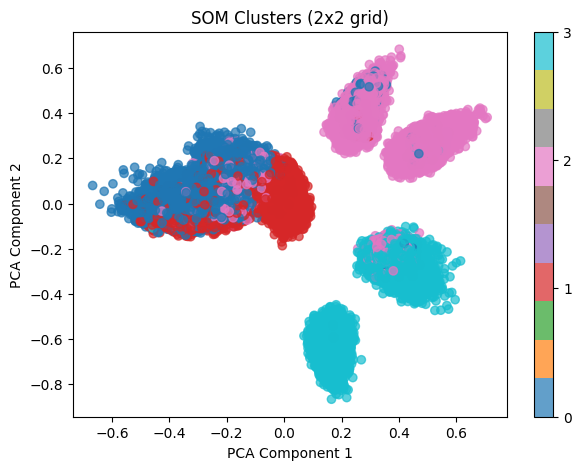

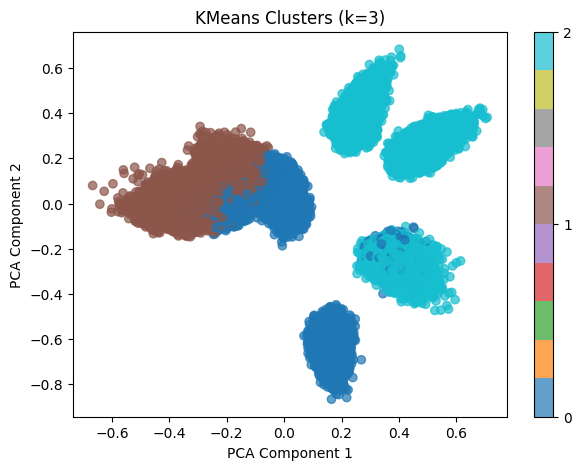

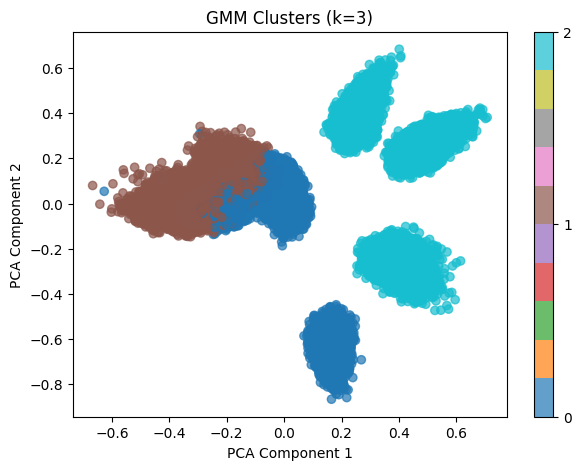

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Reduce embeddings to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

def plot_clusters(embeddings_2d, labels, title):
    plt.figure(figsize=(7,5))
    scatter = plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, ticks=np.unique(labels))
    plt.show()

plot_clusters(embeddings_2d, som_labels, "SOM Clusters (2x2 grid)")
plot_clusters(embeddings_2d, kmeans_labels, "KMeans Clusters (k=3)")
plot_clusters(embeddings_2d, gmm_labels, "GMM Clusters (k=3)")
